# Loss functions

Every supervised learning algorithm is constructed as a ways to minimize some kind of **loss function**. Intuitively, the lower the loss, the better the algorithm has learned.

Data scientists are usually aware of the issue of overfitting: if you give your algorithm enough degrees of freedom, it will "memorize" the training data and achieve zero loss, but without being able to generalize to new data. Techniques such as regularization and dropoout are means to avoid overfitting; we won't discuss them in this session, and assume they are being taken care of.

Instead, we will focus on a more fundamental question: what is a good choice for a  loss function?

## Loss functions: executive summary
We start with the conclusions for the lazy reader:
* Simply using the standard **log-loss**, and sometimes using **log-loss with weights**, is usually more than enough. 
  - This can be achieved via `class_weight` parameters in many standard algorithms, and worst-case scenario via `sample_weight` in the `.fit` method of all scikit-learn models.
  - A downside (which can be later dealt with) is that adding weights tempers with **model calibration** - see more about it in the Calibration section.
* Given the off-the-shelf LightGBM and XGBoost implementations, we recommend trying to use **focal loss** as an alternative loss function in the imbalanced case

---

## Back to basics: the log-loss

In binary classification, the standard loss function is the **log-loss** (aka binary cross-entropy)

$$\boxed{L( y| q) = - y \log q - (1-y) \log(1-q)}$$

where $y$ is the real label taking values 0 or 1, and $q \in [0,1]$ is a predicted score, $q = q(x) = \widehat{\mathbb P}(Y=1|X=x)$. The logarithm is usually taken to be the natural log (base $e$), although any other base would be equally valid. We take $0 \log 0 \equiv 0$, as would be the natural extension from the limit.

> For example: if we predict a score of $q=0.8$ for a point with $y=1$, this yields a log-loss of $-\log 0.8 = 0.22$.

This function has a few key properties:
* It is zero when we yield a perfectly sure predictor: if $y=1$ and we predict $q=1$, the error is zero. Analogously for $y=0$ and $q=0$.
* It is non-negative: thus, a prediction can be more or less penalized, but there is always some level of penalty.
* **It diverges**: for $y=1$, it diverges at $q \to 0$ and analogously for $y=0$ it diverges at $q \to 1$. This is will be an important point of discussion in the following sections.

### Where does the log-loss come from? The Bernoulli formalism

Recall our probabilistic setup: we consider a pair of jointly distributed variables $(X,Y)$ where $Y$ takes values in $\{0,1\}$. This means that $\mathbb P(Y=1|X=x) \equiv q(x)$ is some function of $x$, and similarly $\mathbb P(Y=0|X=x) = 1 - \mathbb P(Y=1|X=x) = 1-q(x)$. 

We then say that the variable $Y|X=x$ is a **Bernoulli variable** with parameter $q(x)$, and write

$$\boxed{Y|X=x \; \sim \; \mathrm{Bernoulli}(q(x))}$$

The log-loss comes from the following result:

**Proposition**. Let there be $N$ iid random variables $Y_i \sim \mathrm{Bernoulli}(q)$, whose values we observe as $y_1,\ldots, y_N$. The maximum likelihood estimator $\hat q$ of $q$ is the one that maximizes the empirical likelihood function

$$L(q) =  \sum_{i=1}^N [y_i \log q + (1-y_i) \log (1-q)],$$

namely 

$$\hat q = \frac{1}{N} \sum_{i=1}^N y_i$$

*Proof*: notice that we can write the two expressions $\mathbb P(Y=1) =q $ and $\mathbb P(Y=0) = 1 - q$ concisely as 

$$\mathbb P(Y=y) = q^y (1-q)^{1-y}.$$

The joint probability of obtaining the observed values $y_1,\ldots, y_n$ is then 

$$\mathbb P(Y_1 = y_1,\ldots, Y_N = y_N) = \prod_{i=1}^N q^{y_i} (1-q)^{1-y_i}.$$

Taking the log of both sides yields the log-likelihood function,

$$L(q) = \log \prod_{i=1}^N q^{y_i} (1-q)^{1-y_i} = \sum_{i=1}^N [y_i \log q + (1-y_i) \log (1-q)]$$

Maximum likelihood estimation states that we want to find the $q$ value that maximizes this quantity. This is equivalent to minimizing its negative, which is exactly the log-loss, as we wanted to show. $\blacksquare$

### Why do we use the log-loss?

In most cases in binary classification, we use the log-loss as our loss function. Why?

It is a very natural choice. *Any* binary classification problem can be written as a ($x$-dependent) Bernoulli variable, ie. a Bernoulli problem where the parameter $q$ is a function $q(x)$.

Logistic regression, in particular, *explicitly* writes $q(x) \equiv q_\beta(x)$ as a sigmoid,

$$q_\beta(x) = \frac{1}{\displaystyle 1 + e^{-\beta \cdot x}}$$

and so allows us to run gradient descent on $\beta$ via explicit minimization of the log-loss.

### Are there other losses?

Absolutely. Any function which gives a positive number when the predicted score is "far" from the label and a small one otherwise is a valid loss. If this function is furthermore a differentiable function of the parameters, everything gets even better.

* **SVM example**: in linear support vector machines we minimize the **hinge loss**

    $$L_\mathrm{hinge} = \sum_{i=1}^N \max\{0, 1 - y_i (w\cdot x_i+b)\}$$

    where $w\in\mathbb R^n$, $b\in\mathbb R$ (and, here, $y_i \in \{-1, 1\}$). Notice that this is a completely different setup: instead of predicting a score $q$, we predict $ F(x_i) \equiv w \cdot x_i + b$ directly; if this quantity has the same sign as $y_i$, then their product is positive and the loss goes down, whereas if the signs are opposite this increases the loss.

* **AdaBoost**: in the AdaBoost algorithm, one often talks about the **exponential loss** 

  $$L_\mathrm{exp} = \frac{1}{N}\sum_{i=1}^N [y_i e^{-F(x_i)} + (1-y_i) e^{+F(x_i)}]$$
  
  where $F(x)$ is a transformed quantity, related to the predicted probability score (usually, we only take $\mathrm{sign}\;F(x)$ in the end as the predicted variable).
  
  Under the choice [1] of link function
  
  $$q(x) = \frac{1}{\displaystyle 1+e^{-2F(x)}} \quad \Leftrightarrow \quad F(x) = \frac 12 \log \frac{q}{1-q}$$
  
  we can rewrite the loss function as a function of $y$ and the score $q$, in an expression similar to the log-loss:
  
  $$\boxed{L_\mathrm{exp}(y|q) = y \sqrt{\frac{1-q}{q}} + (1-y) \sqrt{\frac{q}{1-q}}.}$$

* **Brier score**: as we will see in the Calibration section, we can define the so-called Brier loss (or Brier score)
  
  $$\boxed{L_\mathrm{Brier}(y|q) = (y-q)^2 = y(1-q)^2 + (1-y)q^2}$$
  
  
* **Focal loss**: for completeness, we write out here the focal loss, which we will discuss in the section about imbalanced learning:

  $$\boxed{L_\mathrm{focal}(y|q) = -y (1-q)^\gamma \log q - (1-\eta) q^\gamma \log(1-q)}$$

## Possible issues with our loss functions

As we have mentioned before, the log-loss has divergent behavior for $q = 0$ and $q=1$. Let us study that further.

To make things simpler, we will assume $y=1$; the discussion is completely analogous for $y=0$. Then, our log-loss is simply

$$L(y|q) = - \log q.$$

This function diverges *exponentially* for $q \to 0$ and *linearly* goes to 0 at $q=1$. See the figure below, where we also plot other loss functions that we have seen above:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.rcParams['figure.dpi'] = 120

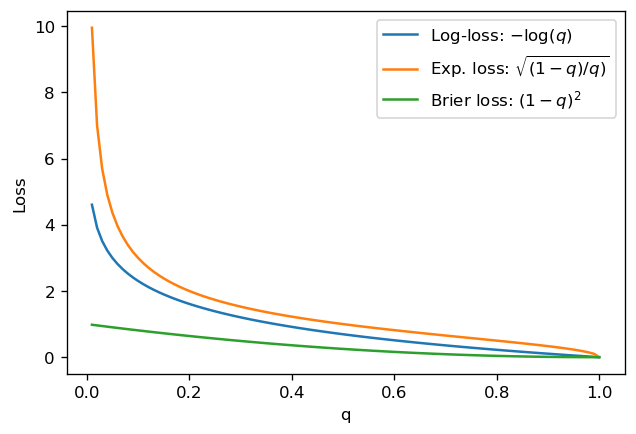

In [2]:
q = np.linspace(0.01,1,100)
plt.plot(q, -np.log(q), label='Log-loss: $-\log (q)$')
plt.plot(q, np.sqrt((1-q)/q), label='Exp. loss: $\sqrt{(1-q)/q)}$')
plt.plot(q, (1-q)**2, label='Brier loss: $(1-q)^2$')

plt.xlabel('q'); plt.ylabel('Loss')
plt.legend()
plt.show()

The behavior we see for the log-loss is that it heavily penalizes misclassified points, due to the exponential behavior - which is good - but only decreases linearly as we classify correctly - which isn't great. 

Ideally, in many applications, you would like points which are "easier to classify" (meaning that the score is close to the actual label 0 or 1) to be "taken care of" first, and then deal with points which are harder to classify. For a classification problem, these are the points close to 0.5 (assuming good model calibration). 

Notice that for the exponential loss, these characteristics (diverging at 0, slowly going to 0 at 1) are even more pronounced. The Brier loss has the issue that it doesn't penalize enough points with low $q$ here.

In other words, for all cases here, both misclassified and well-classified points count significantly towards the loss, with a higher contribution from misclassifications (and a particularly higher contribution in the case of log-loss and exponential loss).

**For those who have read the Appendix on proper scoring rules**

The issue is that all losses in the Beta family have weights of the form $\omega(q) = q^{\alpha-1} (1-q)^{\beta-1}$; as we can see in the plot below, for all values of $\alpha <1$, we have the same behavior: convex curves which diverge at $q=0$ and $q=1$. Therefore, qualitatively, they all have similar behaviors as log-loss. For $\alpha=1$ (which corresponds to the Brier score), all values are equally weighted and the loss function doesn't have enough discriminative power.

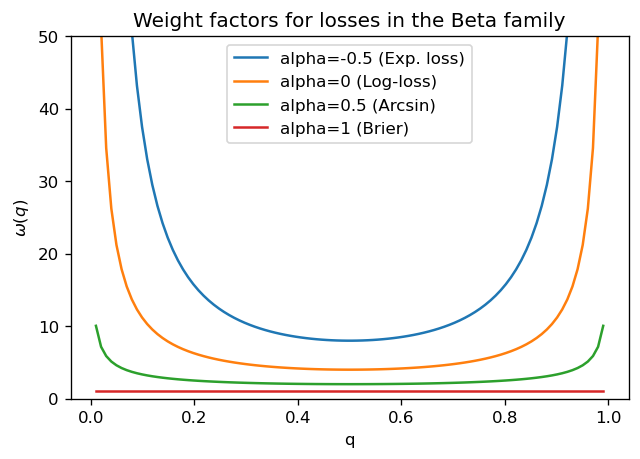

In [3]:
q = np.linspace(0.01, 0.99, 100)
for alpha, name in zip([-0.5, 0, 0.5, 1], ['Exp. loss', 'Log-loss', 'Arcsin', 'Brier']):
    plt.plot(q, (q*(1-q))**(alpha-1), label=f'alpha={alpha} ({name})')

plt.legend()
plt.ylim(0,50)
plt.xlabel("q"); plt.ylabel("$\omega(q)$"); plt.title("Weight factors for losses in the Beta family")
plt.show()

In fact, we can explicitly use the expression

$$L(y|q) = y B(1-q; \beta+1, \alpha) + (1-y) B(q; \alpha+1,\beta)$$

for the losses, and compute them explicitly. As before, take $y=1$ and study that case particularly:


In [4]:
def incomplete_beta(x, a, b):
    from scipy.special import beta, betainc
    
    eps = 1e-6 # for numerical stability
    return beta(a+eps, b+eps) * betainc(a+eps, b+eps, x)

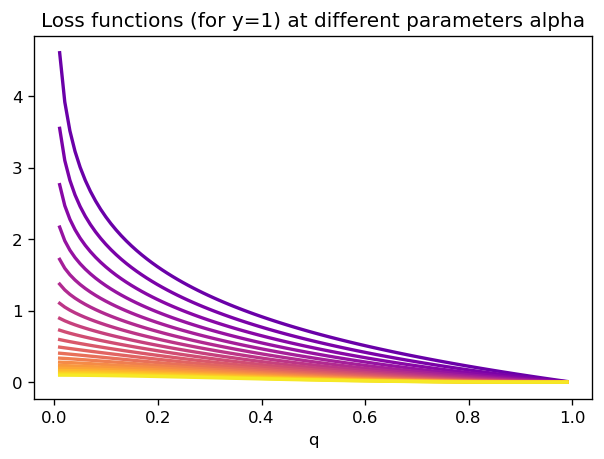

In [5]:
for a in np.arange(-0.5, 2, 0.1):
    plt.plot(q, incomplete_beta(1-q, a+1, a), c=cm.plasma((a+0.5)/2.5), linewidth=2)
plt.title("Loss functions (for y=1) at different parameters alpha")
plt.xlabel("q")
plt.show()

We can the study all these losses' behavior close to $q=1$. Taylor series are easy to calculate there, since our function $q \mapsto B(1-q;\beta+1,\alpha)$ is described as an integral of polynomial-like quantities. Hence, we should not expect eg. exponential weighings close to 1, only polynomial behavior.

In conclusion, the Beta family provides us with a class of functions which diverge at the origin $q=0$, and are polynomially behaved at $q=1$ (of course, the opposite is true if we study the loss function for $y=0$). This will affect how they perform in imbalanced cases, as we will see below.

---

# Losses for imbalanced classification

In the imbalanced classification case, as usual, one needs to be careful. Below, we show some common strategies applied to an artificial dataset with 99:1 imbalance between classes. 

In [6]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer

In [7]:
X, y = make_classification(n_samples=20000, n_features=10, n_informative=8, n_redundant=1, n_repeated=1, 
                           random_state=10,
                           weights=(0.99,)) ## 99 to 1 proportion between classes

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y, # don't forget to stratify
                                                    random_state=1, test_size=0.3)

## Doing nothing

What if we simply try to instantiate a model and fit it?

(Instead of cross-validation, we will be using simple train/test splits here to focus on the different methods)

In [8]:
# first model: gradient boosting
model = HistGradientBoostingClassifier(random_state=2)
model.fit(X_train, y_train)

y_probs = model.predict_proba(X_test)[:,1]
print("AUC: {0:.3f}".format(roc_auc_score(y_test, y_probs)))
print("AP:  {0:.3f}".format(average_precision_score(y_test, y_probs)))

AUC: 0.819
AP:  0.424


In [9]:
# second model: random forest
model = RandomForestClassifier(random_state=2)
model.fit(X_train, y_train)

y_probs = model.predict_proba(X_test)[:,1]
print("AUC: {0:.3f}".format(roc_auc_score(y_test, y_probs)))
print("AP:  {0:.3f}".format(average_precision_score(y_test, y_probs)))

AUC: 0.820
AP:  0.451


In [10]:
# third model: logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)

y_probs = model.predict_proba(X_test)[:,1]
print("AUC: {0:.3f}".format(roc_auc_score(y_test, y_probs)))
print("AP:  {0:.3f}".format(average_precision_score(y_test, y_probs)))

AUC: 0.768
AP:  0.213


These will serve as our baseline models.

## Weighting

We can easily add weights to different training instances. Effectively, this means considering a weight vector $w_i$ (one entry for each training sample) and the weighted loss

$$L_\mathrm{weighted} = \sum_{i=1}^N w_i L(y_i|q_i)$$

> Assume we set $w_i=1$ for all points in the majority class, and $w_i > 1$ for points in the minority, positive class. Then, this procedure is mathematically equivalent to an *oversampling* strategy where each point in the minority class gets copied $w_i$ times.

> Because of this, issues pertaining to *model calibration*, ie. faithful prediction of probabilities by the classifier, will be affected. See section on Calibration.

In scikit-learn, there are two ways of doing this. We illustrate them both below:

**1)  Direcly pass weights to** `.fit`

Let us build a weight vector which will **give more weight to the minority class**. Any choice would work, but we will specifically pick this one: let $f_1, f_0$ denote the relative frequency of classes 1 and 2 (here, $f_1 \approx 0.01$ and $f_0 \approx 0.99$; the approximation comes from the fact that `y_train` does not exactly keep the proportions perfect when stratified from `y`) 

$$w_i = \begin{cases}
\frac{1}{2 f_1} & \mbox{if } y_i = 1\\
\frac{1}{2 f_0} & \mbox{if } y_i = 0
\end{cases}$$

In [230]:
n0, n1 = np.bincount(y_train)
weights = np.where(y_train==1, len(y_train)/(2*n1), len(y_train)/(2*n0))

We can now retrain our gradient boosting classifier as follows:

In [231]:
# first model: gradient boosting
model = HistGradientBoostingClassifier(random_state=2)
model.fit(X_train, y_train, sample_weight=weights)

y_probs = model.predict_proba(X_test)[:,1]
print("AUC: {0:.3f}".format(roc_auc_score(y_test, y_probs)))
print("AP:  {0:.3f}".format(average_precision_score(y_test, y_probs)))

AUC: 0.819
AP:  0.374


In [232]:
# second model: random forest
model = RandomForestClassifier(random_state=2)
model.fit(X_train, y_train, sample_weight=weights)

y_probs = model.predict_proba(X_test)[:,1]
print("AUC: {0:.3f}".format(roc_auc_score(y_test, y_probs)))
print("AP:  {0:.3f}".format(average_precision_score(y_test, y_probs)))

AUC: 0.821
AP:  0.486


In [233]:
# third model: logistic regression
model = LogisticRegression()
model.fit(X_train, y_train, sample_weight=weights)

y_probs = model.predict_proba(X_test)[:,1]
print("AUC: {0:.3f}".format(roc_auc_score(y_test, y_probs)))
print("AP:  {0:.3f}".format(average_precision_score(y_test, y_probs)))

AUC: 0.780
AP:  0.118


We see that adding weights improved the performance of the random forest and logistic regression classifiers in terms of AUC; it didn't do much for gradient boosting (and in fact we had some loss average-precision wise).

**2) Class weights on model instantiation**

Some scikit-learn classifiers have a `class_weight` attribute. What it does is that it receives a dictionary `{0: w_0, 1: w_1}` for weights to give to elements of each class.

Instead of passing this dictionary by hand, we can also use `class_weight='balanced'` to automatically give more weights to the minority class.

In most classifiers, this is equivalent to the weight rule we used above: you will see we get exactly the same results for both `RandomForestClassifier` and `LogisticRegression`:

In [11]:
# second model: random forest
model = RandomForestClassifier(random_state=2, class_weight='balanced')
model.fit(X_train, y_train)

y_probs = model.predict_proba(X_test)[:,1]
print("AUC: {0:.3f}".format(roc_auc_score(y_test, y_probs)))
print("AP:  {0:.3f}".format(average_precision_score(y_test, y_probs)))

AUC: 0.821
AP:  0.486


In [12]:
# third model: logistic regression
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

y_probs = model.predict_proba(X_test)[:,1]
print("AUC: {0:.3f}".format(roc_auc_score(y_test, y_probs)))
print("AP:  {0:.3f}".format(average_precision_score(y_test, y_probs)))

AUC: 0.780
AP:  0.118


`HistGradientBoostingClassifier` however does not have a `class_weight` attribute; for it, we need to specity `sample_weight`.

**Weights can be cross-validated**

As we just saw here, the choice of weights can be thought of as yet another hyperparameter to cross-validate. 

### Weights change the threshold distribution

Let us plot two ROC curves for the logistic regression model: one raw, and one with class weights. In each, we will also plot the different thresholds corresponding to each point.

In [13]:
def complete_plot_roc(y_true, y_probs, ax, threshold_step=0.1):
   
    """
    Run full ROC diagnostic
    """
   
    from sklearn.metrics import roc_curve, roc_auc_score
    from matplotlib.cm import viridis as mycolormap
   
    fpr, tpr, thresh = roc_curve(y_true, y_probs)
   
    # x axis, y axis
    x = fpr
    y = tpr
 
    auc = roc_auc_score(y_true, y_probs)
 
    # color
    c = thresh
    c[0] = c[0]-1
    c = (c - c.min())/(c.max() - c.min())
 
    base = 1.0 - threshold_step
    for i in range(len(x)):
        ax.plot(x[i:i+2], y[i:i+2], c=mycolormap(c[i]))
 
        if thresh[i] <= base:
            ax.scatter(x[i], y[i], color=mycolormap(c[i]))
            ax.annotate("  {0:.1f}".format(thresh[i]), (x[i]*1.03, y[i]*0.96), fontsize=8)
            base -= threshold_step
   
    ax.annotate("AUC = {0:.2f}".format(auc), (0.77, 0.01), fontsize=8,
               bbox=dict(facecolor='none', edgecolor='black', pad=5.0))
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
   
    return

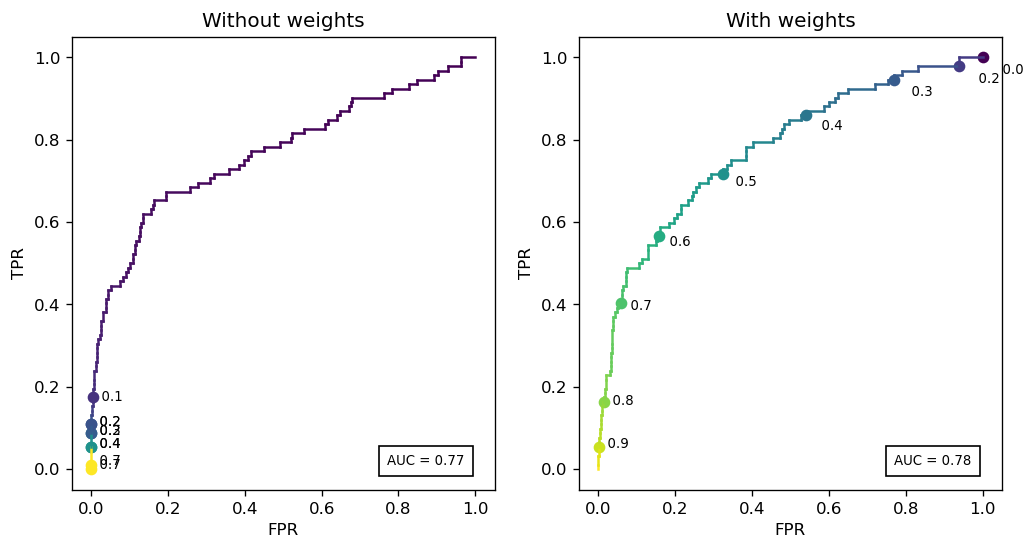

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

# without weights
model = LogisticRegression(random_state=2)
model.fit(X_train, y_train)
y_probs_raw = model.predict_proba(X_test)[:,1]
complete_plot_roc(y_test, y_probs_raw, ax[0])
ax[0].set_title("Without weights")

# with weights
model = LogisticRegression(random_state=2, class_weight='balanced')
model.fit(X_train, y_train)
y_probs_weights = model.predict_proba(X_test)[:,1]
complete_plot_roc(y_test, y_probs_weights, ax[1])
ax[1].set_title("With weights")

plt.show()

Notice that the raw model heavily skews the threshold range: almost 80% of the curve lies within thresholds 0 and 0.1. 

Is this a bad thing? Again, it depends. We affected model calibration in exchange for 1 point in AUC.

## Focal loss

The **focal loss** was introduced by the team at Facebook research in [2], in the context of object detection. It is a loss function specialized in imbalanced classification, which we present below.

Recall that the standard log-loss for a single point is

$$L(y|q) = - y \log q - (1-y) \log(1-q)$$

The authors in [2] propose a modification to this expression which adds an **exponential decay term** close to $q=1$:

  $$\boxed{L_\mathrm{focal}(y|q) = -y (1-q)^\gamma \log q - (1-\eta) q^\gamma \log(1-q)}$$

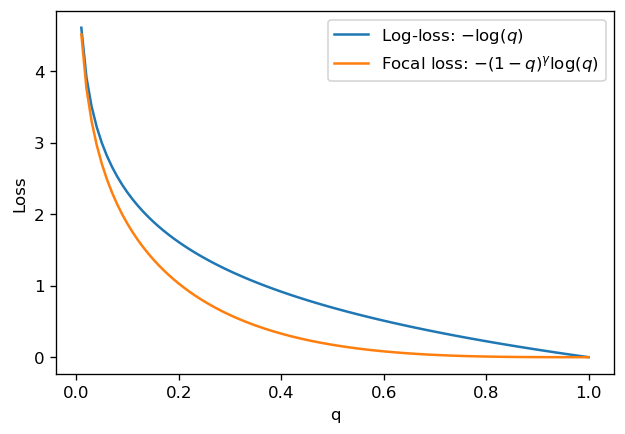

In [15]:
gamma = 2
q = np.linspace(0.01,1,100)
plt.plot(q, -np.log(q), label='Log-loss: $-\log (q)$')
plt.plot(q, -(1-q)**gamma * np.log(q), label='Focal loss: $-(1-q)^\gamma \log (q)$')

plt.xlabel('q'); plt.ylabel('Loss')
plt.legend()
plt.show()

* For $q \approx 0$, the focal loss behaves very similarly to the log-loss; this is expected, since for small $q$, $L_\mathrm{focal}/L_\mathrm{log-loss} \approx 1 - \gamma q \to 1$. 
* However, for $q$ closer to 1, the exponential decay quickly makes the loss go to 0. This means that the focal loss cares much less about "easily classifiable" points, and instead focuses on **learning points which are harder to classify**.

### LightGBM implementation of focal loss

We have [implemented](https://github.com/pibieta/imbalanced_learning/blob/main/notebooks/focal_lgbm.py) a version of the standard LightGBM classifier which uses focal loss.
The rationale behind doing this in LightGBM is that it is a library which allows implementation of user-defined losses, as long as we also have the Jacobian/Hessian of that loss. 

In [16]:
import lightgbm as lgb
from focal_lgbm import FocalLossLGBM

First, we set a benchmark with the standard LightGBM classifier:

In [17]:
model = lgb.LGBMClassifier(random_state=0)
model.fit(X_train, y_train)
y_probs = model.predict_proba(X_test)[:,1]
print("AUC: {0:.3f}".format(roc_auc_score(y_test, y_probs)))
print("AP:  {0:.3f}".format(average_precision_score(y_test, y_probs)))

AUC: 0.834
AP:  0.424


Then, we try the model with focal loss. Below, `alpha` is actually a weight similar to `w_i` in the discussions above. All other parameters aside from `gamma` are the same ones in standard LightGBM.

In [18]:
model =  FocalLossLGBM(alpha=0.5, gamma=0.5, 
                      verbose=-1, random_state=0)

model.fit(X_train, y_train)
y_probs = model.predict_proba(X_test)[:,1]
print("AUC: {0:.3f}".format(roc_auc_score(y_test, y_probs)))
print("AP:  {0:.3f}".format(average_precision_score(y_test, y_probs)))

AUC: 0.845
AP:  0.485


The focal loss model performed better! In fact, with a little cheating, we can get it even better:

In [19]:
model =  FocalLossLGBM(alpha=0.5, gamma=0.5, 
                      learning_rate= 0.1,
                      n_estimators=500,
                      num_leaves=63,
                      verbose=-1, random_state=0)

model.fit(X_train, y_train)
y_probs = model.predict_proba(X_test)[:,1]
print("AUC: {0:.3f}".format(roc_auc_score(y_test, y_probs)))
print("AP:  {0:.3f}".format(average_precision_score(y_test, y_probs)))

AUC: 0.863
AP:  0.530


In this particular case, the model with focal loss performed better than the baseline LightGBM and the other models.

**The whole point here is to optimize for hyperparameters.** The choice of loss is also a hyperparameter!

### XGBoost implementation of focal loss

The team in [3] has made available an implementation of focal loss in XGBoost (https://github.com/jhwjhw0123/Imbalance-XGBoost). Let us test it here as well:

In [ ]:
#!pip install imbalance-xgboost

In [21]:
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb

/home/c91852a/.conda/envs/2022/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [33]:
xgboster = imb_xgb(special_objective='focal', focal_gamma=1.0, eta=0.1, num_round=100, imbalance_alpha=0.5)

In [34]:
xgboster.fit(X_train, y_train)
y_probs = xgboster.predict_sigmoid(X_test)
print("AUC: {0:.3f}".format(roc_auc_score(y_test, y_probs)))
print("AP:  {0:.3f}".format(average_precision_score(y_test, y_probs)))

AUC: 0.869
AP:  0.490


This model (with a little tuning) performed even better than our LightGBM implementation!

# Conclusions

* We obtained good results simply using **log-loss with weights** (via `class_weight` or `sample_weight`)
* We were able to get even better results from **focal loss** via the LightGBM and XGBoost implementations in the imbalanced case, and we recommend trying it out

# Appendix: proper scoring rules

## Expected losses

All loss functions discussed here can be written in the form

$$\boxed{L(y|q) = y L_1(1-q) + (1-y)L_0(q)}.$$

Here, we have explicitly written that $L$ depends on $y$ *conditioned on* the predicted score $q$. Notice that this is the only dependence that $y$ has on $x$, namely via $q = q(x)$. 

*Example*: for the log-loss, 

\begin{align*}
L_0(q) &= - \log(1-q)\\
L_1(1-q) &= -\log q \quad \Rightarrow L_1(u) = - \log(1-u) = L_0(u)
\end{align*}

Notice that both functions are equal, but functions of different variables.

*Example*: for the Brier loss,

$$L_0(q) = q^2, \quad L_1(1-q) = (1-q)^2.$$

In what follows, **we fix a point $X=x$**. Write $Y|X=x$ as simply $Y$ as an abuse of notation. Then, 

$$Y \sim \mathrm{Bernoulli}(\eta)$$

where $\eta = \mathbb P(Y=1)$ (really $\mathbb P(Y=1|X=x)$). 

We define the **expected loss**

$$\boxed{R(\eta|q) = \mathbb E_Y L(Y|q).}$$

It is a function of two variables: the real Bernoulli parameter $\eta$, and the predicted score $q$. 

Intuitively, what do we want? If we predict the parameter perfectly (ie. $q = \eta$) we would expect $R$ to be minimized. This is a logical desideratum, but it is not obvious, and it motivates the following:


### Proper scoring rules 
A loss function $L(y|q)$ is a **proper scoring rule** if the expected loss $q \mapsto R(\eta|q)$ is minimized by $q=\eta$. It is further described as **strict** if $\eta$ is the global minimizer.

Notice that we can write, since $\mathbb E[Y] =\eta$ if $Y \sim \mathrm{Bernoulli}(\eta)$:

$$\boxed{R(\eta|q) = \eta L_1 (1-q) + (1-\eta) L_0(q)}$$

Not everything is a proper scoring rule. The losses we mentioned above definitely are, but ROC AUC or Average Precision, for instance, are not. In fact, proper scoring rules have very interesting properties, which we now lay out:

**Theorem** [Shuford-Albert-Massengil] 

$L(y|p)$ is a proper scoring rule if and only if there exists a **weight function** $\omega: [0,1] \to \mathbb R_+$ such that

$$\frac{d L_1(1-q)}{d(1-q)} = \omega(q) (1-q),\qquad \frac{d L_0}{dq} = \omega(q) q;$$

if these are bounded below, then the equations can be integrated to give

$$L_1(1-q) = \int_q^1 (1-c) \omega(c) dc,\qquad L_0(q) = \int_0^q c \omega(c) dc,$$

[and in fact, this is the general form regardless of smoothness, due to a theorem by Schervish 1989].  

In the case of twice-differentiable $R$, 

$$\boxed{\omega(\eta) = \left.\frac{\partial^2 R(\eta|q)}{\partial q^2} \right|_{q = \eta}}$$

*Example*: consider again the log-loss, where $L(y|q) = - y \log q - (1-y) \log (1-q)$. The expected loss is

$$R(\eta|q) = -\mathbb E[y] \log q - (1-\mathbb E[y]) \log(1-q) = - \eta \log q - (1-\eta)\log(1-q).$$

Differentiating, we get

$$\frac{\partial R}{\partial q} = - \frac{\eta}{q} + \frac{1-\eta}{1-q};\quad \frac{\partial^2 R}{\partial q^2} =  \frac{\eta}{q^2} + \frac{1-\eta}{(1-q)^2}$$

$$\Rightarrow \omega(\eta) = \left.\frac{\partial^2 R}{\partial q^2}\right|_{q=\eta} = \frac{1}{\eta (1-\eta)}.$$

### The weight function: the unifier of proper scoring rules

The calculation in the example above is actually interesting because it shows that this weight function (which we haven't interpreted yet) diverges at both $\eta = 0$ and $\eta = 1$, similarly to how the log-loss itself does.

To motivate the reasoning of $\omega$ as a weight, we notice a theorem by Shuford, Albert, Massengil, Savage and Scherviss (see [1]) which states the following:

Fix $0 < c < 1$, and let

$$\boxed{L_c(y|q) = y(1-c) 1_{q \leq c} + (1-y) c 1_{q>c}}$$

be a **cost-weighted misclassification error**: it penalizes false positives with cost $c$ and false negatives with cost $1-c$.

Then, any proper scoring rule can be written as 

$$\boxed{L(y|p) = \int_0^1 L_c(y|p) \,\omega(c) dc}$$



**This result is extremely interesting**. It is a **unified vision** of all the different loss functions we saw so far: if we consider the simplest loss function, which penalizes both false positive and negatives, and integrate it against a weight function $\omega(c)$ for all possible costs $c$, we arrive at a loss function which is a proper scoring rule! 

In fact, it shows that the degree of freedom in choosing a proper scoring rule **lies in the choice of the weight function**, period. 

> Exercise: starting from $\omega(c) = [c(1-c)]^{-1}$, obtain the log-loss.

### The Beta family of proper scoring rules

In the discussion above, we saw a unified approach to creating loss functions which are proper scoring rules. We can go one step beyond, and show that they all (except the focal loss) *belong in the the same family of functions!*

Recall that

$$\omega_\mathrm{log-loss}(q) = \frac{1}{q(1-q)}$$

For the exponential loss, 

$$L(y|q) = y \sqrt{\frac{1-q}{q}} + (1-y) \sqrt{\frac{q}{1-q}}$$

we have an actually similar weight function

$$\omega_\mathrm{exp}(q) = \left(\frac{1}{q(1-q)}\right)^{3/2}$$

We can actually introduce a parametric family of functions which include all these as well as the Brier score and misclassification loss: the **Beta family**

$$\boxed{\omega_{\alpha,\beta}(q) := q^{\alpha-1} (1-q)^{\beta-1}}$$

where the name is obviously motivated by the [Beta function](https://en.wikipedia.org/wiki/Beta_function).

Then:
* $\alpha=\beta=-1/2$: exponential loss
* $\alpha=\beta=0$: log-loss
* $\alpha=\beta=1$: Brier (squared error) loss
* $\alpha=\beta\to\infty$: misclassification loss (weak convergence to delta mass)

Also, any values of $\alpha$ and $\beta$ which are multiples of $1/2$ yield closed-form formulas for $\omega$. For example, if $\alpha=\beta=1/2$, we get an intermediate between log-loss and squared error loss:
$$L(y|q) = y (\arcsin\sqrt{1-q} - \sqrt{q(1-q)}) + (1-y) (\arcsin\sqrt{q} - \sqrt{q(1-q)})$$

In general, if we define the (non-regularized) **incomplete Beta function**

$$B(x; a, b) := \int_0^x t^{a-1} (1-t)^{b-1} dt$$

then we can explicitly write the loss functions for the Beta family as 

$$\boxed{L(y|q) = y B(1-q; \beta+1, \alpha) + (1-y) B(q; \alpha+1,\beta)}$$

---

# References

[1] Andreas Buja, Werner Stuetzle, Yi Shen. *Loss Functions for Binary Class Probability Estimation and Classification: Structure and Applications* (2015)

[2] Tsung-Yi Lin, Priya Goyal, Ross Girshick, Kaiming He, Piotr Dollár. *Focal Loss for Dense Object Detection*. Available on https://arxiv.org/abs/1708.02002

[3] Chen Wang and Chengyuan Deng and Suzhen Wang, *Imbalance-XGBoost: Leveraging Weighted and Focal Losses for Binary Label-Imbalanced Classification with XGBoost*. Available in https://arxiv.org/abs/1908.01672 (2019)